# Introduction

This kernel builds a Neural Network Model using Word Embedding (a paramount feature Natural Language Processing) to classify whether a message is Spam or not.

The Dataset consists of 5572 sentences with about 87% labelled as spam message and 13% labelled as ham.

P:S I know there is a huge class imbalance which will affect it's generalization to an unseen data, don't worry read on to see how I tackle this.  



This project workflow includes:

- Loading the data  
- Examining and understanding the dataset
- Preprocess the Text Data
- Building an input pipeline
- Building an Input Pipeline for the Pretrained Embedding Model
- Building an Input Data Pipeline for the Encoded Text Sequences
- Building a NN Model using a Model Subclassing API
- Training the model
- Evaluating the model using Sklearn's confusion_matrix


All these will be done with tensorflow 2.x.

In [82]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import gensim.downloader as api
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import os

# Load the Data

In [55]:
import pandas as pd
spam = pd.read_csv("spam.csv", encoding = 'ISO-8859-1')

In [56]:
spam = spam.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [57]:
def format(v1):
    if v1 == "spam":
        return 1
    else:
        return 0
    
spam["v1"] = spam["v1"].apply(format)

In [58]:
spam["v1"].value_counts(normalize=True) * 100

0    86.593683
1    13.406317
Name: v1, dtype: float64

In [59]:
no_spam = spam[spam["v1"] == 0]
spam_msg = spam[spam["v1"] == 1]

In [60]:
no_spam[15:20]

,v1,v2
23,0,Aft i finish my lunch then i go str down lor. ...
24,0,Ffffffffff. Alright no way I can meet up with ...
25,0,Just forced myself to eat a slice. I'm really ...
26,0,Lol your always so convincing.
27,0,Did you catch the bus ? Are you frying an egg ...


In [61]:
spam_msg[4:30]

,v1,v2
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
12,1,URGENT! You have won a 1 week FREE membership ...
15,1,"XXXMobileMovieClub: To use your credit, click ..."
19,1,England v Macedonia - dont miss the goals/team...
34,1,Thanks for your subscription to Ringtone UK yo...
42,1,07732584351 - Rodger Burns - MSG = We tried to...
54,1,SMS. ac Sptv: The New Jersey Devils and the De...
56,1,Congrats! 1 year special cinema pass for 2 is ...
65,1,"As a valued customer, I am pleased to advise y..."
67,1,Urgent UR awarded a complimentary trip to Euro...


# Text Data Preprocessing

In [62]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(spam["v2"])
text_sequences = tokenizer.texts_to_sequences(spam["v2"])
text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences)

num = len(text_sequences)
max_sqlen = len(text_sequences[0])

print("{:d} sentences, max length: {:d}".format(num, max_sqlen))

5572 sentences, max length: 189


In [63]:
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
word2idx["PAD"] = 0
idx2word[0] = "PAD"
vocab_size = len(word2idx)
print("vocab size: {:d}".format(vocab_size))

vocab size: 8921


# Build an Input Pipeline for the Pretrained Embedding Model

In [64]:
def build_embedding_matrix(sequences, word2idx, embedding_dim, embedding_file):
    if os.path.exists(embedding_file):
        F = np.load(embedding_file)
        
    else:
        vocab_size = len(word2idx)
        F = np.zeros((vocab_size, embedding_dim))
        word_vectors = api.load(EMBEDDING_MODEL)
        for word, idx in word2idx.items():
            try:
                F[idx] = word_vectors.word_vec(word)
            except KeyError:
                pass
            
        np.save(embedding_file, F)
    return F

EMBEDDING_DIM = 300
DATA_DIR = "Data"
EMBEDDING_NUMPY_FILE = os.path.join(DATA_DIR, "F.npy")
EMBEDDING_MODEL =  "glove-wiki-gigaword-300"

F = build_embedding_matrix(text_sequences, word2idx, EMBEDDING_DIM,EMBEDDING_NUMPY_FILE)

print("Embedding matrix:", F.shape)

Embedding matrix: (8921, 300)


#  Build an Input Data Pipeline for the Encoded Text Sequences

In [65]:
# For Reproducible result
np.random.seed(40)
tf.random.set_seed(40)

In [66]:
NUM_CLASSES = 2
cat_labels = tf.keras.utils.to_categorical(spam["v1"], num_classes=NUM_CLASSES)

In [67]:
dataset = tf.data.Dataset.from_tensor_slices((text_sequences, cat_labels))
dataset = dataset.shuffle(10000)
test_size = num // 4
val_size = (num - test_size) // 10
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size )
BATCH_SIZE = 128
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Build a Model using Model Subclassing API

In [68]:
class SpamClassifierModel(tf.keras.Model):
    def __init__(self, vocab_sz, embed_sz, input_length, num_filters, kernel_sz, output_sz, run_mode, embedding_weights, **kwargs):
        super(SpamClassifierModel, self).__init__(**kwargs)
        
        if run_mode == "scratch":
            self.embedding = tf.keras.layers.Embedding(vocab_sz, embed_sz, input_length=input_length, trainable=True)
        elif run_mode == "vectorizer":
            self.embedding = tf.keras.layers.Embedding(vocab_sz, embed_sz, input_length=input_length, weights=[embedding_weights], trainable=False)
        elif run_mode == "fine_tuning":
            self.embedding = tf.keras.layers.Embedding(vocab_sz, embed_sz, input_length=input_length, weights=[embedding_weights], trainable=True)
        
        self.conv = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_sz, activation="relu")
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.pool = tf.keras.layers.GlobalMaxPooling1D()
        self.dense = tf.keras.layers.Dense(output_sz, activation="softmax")
        
    def call(self, x):
        x = self.embedding(x)
        x = self.conv(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.dense(x)
        return x

In [73]:
conv_num_filters = 256
conv_kernel_size = 3
model = SpamClassifierModel(vocab_size, EMBEDDING_DIM, max_sqlen,conv_num_filters, conv_kernel_size, NUM_CLASSES, "fine_tuning", F)


model.build(input_shape=(None, max_sqlen))

In [74]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [75]:
checkpoint = ModelCheckpoint("spam_detector_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(patience = 10, restore_best_weights = True)
callbacks_list = [checkpoint, early_stopping]

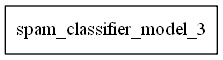

In [76]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Train the Model


- One thing to notice is that dataset is somewhat imbalanced - The dataset consists of about 87% instances of spam and about 13% instances of ham.
- The network could achieve an apprx accuracy of 87% by simply predicting the majority class.
- To alleviate this problem, I'll set the class weight to implement a harsh penalty for misclassifying the minority class


In [77]:
CLASS_WEIGHTS = {0:1, 1:8}

In [85]:
model.fit(train_dataset, epochs=10, validation_data=val_dataset, class_weight=CLASS_WEIGHTS, callbacks=callbacks_list)

Train for 29 steps, validate for 3 steps
Epoch 1/5
28/29 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9980
Epoch 00001: val_accuracy did not improve from 1.00000
29/29 [==============================] - 33s 1s/step - loss: 0.0173 - accuracy: 0.9981 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 2/5
28/29 [===========================>..] - ETA: 1s - loss: 0.0101 - accuracy: 0.9994
Epoch 00002: val_accuracy did not improve from 1.00000
29/29 [==============================] - 33s 1s/step - loss: 0.0134 - accuracy: 0.9992 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 3/5
28/29 [===========================>..] - ETA: 1s - loss: 0.0098 - accuracy: 0.9997
Epoch 00003: val_accuracy did not improve from 1.00000
29/29 [==============================] - 33s 1s/step - loss: 0.0097 - accuracy: 0.9997 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 4/5
28/29 [===========================>..] - ETA: 1s - loss: 0.0063 - accuracy: 1.0000
Epoch 00004: val_accuracy did not i

# Evaluate the Model 

In [86]:
model.save_weights("spam.h5")

In [87]:
labels, predictions = [], []
for X_test, Y_test in test_dataset:
    Y_test_ = model.predict_on_batch(X_test)
    y_test = np.argmax(Y_test, axis=1)
    y_test_ = np.argmax(Y_test_, axis=1)
    labels.extend(y_test.tolist())
    predictions.extend(y_test.tolist())
    
print("test accuaracy: {:.3f}".format(accuracy_score(labels, predictions)))
print("confusion_matrix")
print(confusion_matrix(labels, predictions))

test accuaracy: 1.000
confusion_matrix
[[1113    0]
 [   0  167]]


In [89]:
score = model.evaluate(test_dataset)
print(score[1])

10/10 [==============================] - 3s 292ms/step - loss: 0.0025 - accuracy: 1.0000
1.0


Please if you like my Kernel, give me an upvote